In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"sapirvered","key":"c7e472ef95ed50b5a7d0f38da8481869"}'}

In [ ]:
!pip -q install kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# load the data from kaggle
!kaggle competitions download -c titanic
!unzip -o titanic.zip

titanic.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  titanic.zip
  inflating: gender_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [ ]:
# Load the dataset and display the first few rows to verify successful loading
import pandas as pd
from IPython.display import display

df = pd.read_csv("train.csv")
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
# Initial exploration: dataset dimensions, feature names, and class balance
print(df.shape)
print(df.columns.tolist())
df.info()
df["Survived"].value_counts(normalize=True)

(891, 12)
['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


,proportion
Survived,
0,0.616162
1,0.383838


In Survived there is a small imbalance between the classes, but it is acceptable.


In [ ]:
(df.isna().mean() * 100).sort_values(ascending=False)

,0
Cabin,77.104377
Age,19.865320
Embarked,0.224467
PassengerId,0.000000
Name,0.000000
Pclass,0.000000
Survived,0.000000
Sex,0.000000
Parch,0.000000
SibSp,0.000000


Cabin contains a large proportion of missing values and will be dropped.

Age and Embarked have missing values that need to be handled.

In [ ]:
display(pd.crosstab(df["Sex"], df["Survived"], normalize="index"))
display(pd.crosstab(df["Pclass"], df["Survived"], normalize="index"))

Survived,0,1
Sex,,
female,0.257962,0.742038
male,0.811092,0.188908


Survived,0,1
Pclass,,
1,0.370370,0.629630
2,0.527174,0.472826
3,0.757637,0.242363


Survival strongly depends on Sex and Pclass.
Females and first-class passengers survived at much higher rates.

<Axes: title={'center': 'Age distribution'}, ylabel='Frequency'>

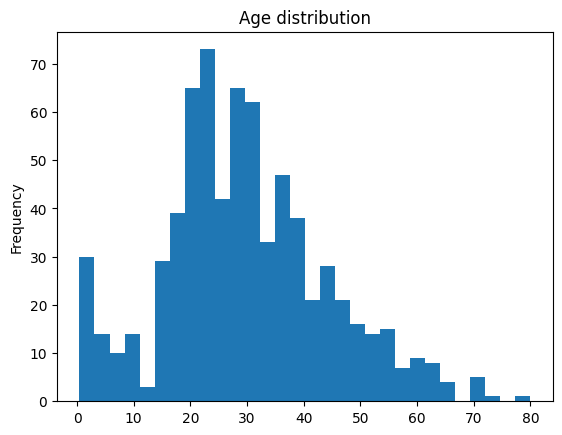

In [ ]:
df["Age"].describe()
df["Age"].plot(kind="hist", bins=30, title="Age distribution")

Age has missing values and a reasonable distribution, making median imputation suitable.

In [ ]:
display(pd.crosstab(df["SibSp"], df["Survived"], normalize="index"))
display(pd.crosstab(df["Parch"], df["Survived"], normalize="index"))

Survived,0,1
SibSp,,
0,0.654605,0.345395
1,0.464115,0.535885
2,0.535714,0.464286
3,0.750000,0.250000
4,0.833333,0.166667
5,1.000000,0.000000
8,1.000000,0.000000


Survived,0,1
Parch,,
0,0.656342,0.343658
1,0.449153,0.550847
2,0.500000,0.500000
3,0.400000,0.600000
4,1.000000,0.000000
5,0.800000,0.200000
6,1.000000,0.000000


Passengers with small family sizes show higher survival rates.


,count,mean,std,min,25%,50%,75%,max
Survived,,,,,,,,
0,549.0,22.117887,31.388207,0.0,7.8542,10.5,26.0,263.0000
1,342.0,48.395408,66.596998,0.0,12.4750,26.0,57.0,512.3292


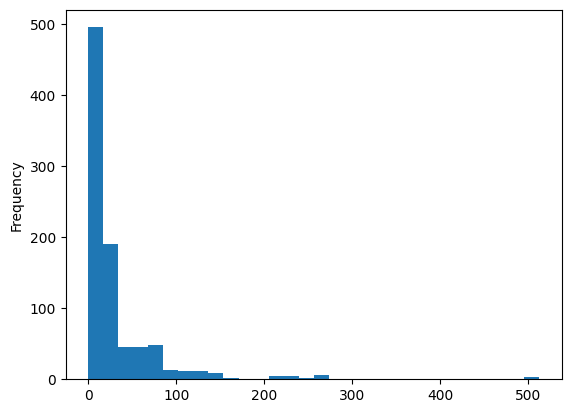

In [ ]:
df["Fare"].describe()
df["Fare"].plot(kind="hist", bins=30)
df.groupby("Survived")["Fare"].describe()



Higher ticket fares are associated with higher survival rates, likely reflecting passenger class and access to safer locations.


In [ ]:
pd.crosstab(df["Embarked"], df["Survived"], normalize="index")


Survived,0,1
Embarked,,
C,0.446429,0.553571
Q,0.610390,0.389610
S,0.663043,0.336957


Embarked shows moderate differences in survival rates and will be encoded as a categorical feature.

EDA Conclusions and Preprocessing Decisions

- Identifier columns such as PassengerId, Name, and Ticket will be excluded, as they do not provide meaningful information for predicting survival.
- The Cabin feature contains a very high proportion of missing values and will therefore be dropped.
- Survived will be used as the target label for the classification task.
- Survival is strongly related to Sex and Pclass, with females and first-class passengers showing significantly higher survival rates.
- Fare, SibSp, and Parch show noticeable variation in survival rates and will be retained as numerical features.
- Age contains missing values but has a reasonable distribution and will be imputed during preprocessing.
- Embarked shows moderate differences in survival rates and will be included as a categorical feature after handling missing values.
- During preprocessing, missing values will be handled, categorical features will be encoded, and numerical features will be scaled before model training.


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

TARGET = "Survived"

NUM_FEATURES = ["Pclass", "Age", "SibSp", "Parch", "Fare"]
CAT_FEATURES = ["Sex", "Embarked"]

X = df[NUM_FEATURES + CAT_FEATURES]
y = df[TARGET]

# Create a reproducible train/validation split (stratified by the target)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    # Ignore unseen categories to allow inference on new/unexpected data
    ("onehot", OneHotEncoder(handle_unknown="ignore")),
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, NUM_FEATURES),
        ("cat", categorical_transformer, CAT_FEATURES),
    ],
    remainder="drop",
)

# Fit preprocessing ONLY on the training data to avoid data leakage
preprocessor.fit(X_train)

# Transform train/val
X_train_proc = preprocessor.transform(X_train)
X_val_proc   = preprocessor.transform(X_val)

X_train_proc.shape, X_val_proc.shape


((712, 10), (179, 10))

In [ ]:
from torch.utils.data import Dataset

class TitanicDataset(Dataset):
    """
    Custom Dataset for the Titanic classification task.
    Returns (features, label) pairs compatible with PyTorch training.
    """
    def __init__(self, X, y):
        # ColumnTransformer may return a sparse matrix.
        # PyTorch models expect dense tensors, so we convert if needed.
        self.X = torch.tensor(X.toarray() if hasattr(X, "toarray") else X, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.float32)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


In [ ]:
# Wrap the processed data with PyTorch Dataset objects
train_dataset = TitanicDataset(X_train_proc, y_train)
val_dataset   = TitanicDataset(X_val_proc, y_val)

len(train_dataset), len(val_dataset)


(712, 179)

In [ ]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32

# DataLoader handles batching and shuffling during training
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
)

# Validation data is not shuffled to ensure consistent evaluation
val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False
)


In [ ]:
# Sanity check: verify batch dimensions and data compatibility with the model
X_batch, y_batch = next(iter(train_loader))
X_batch.shape, y_batch.shape

(torch.Size([32, 10]), torch.Size([32]))

In [ ]:
import torch
import torch.nn as nn

class TitanicModel(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.model(x).squeeze(1)

In [ ]:
input_dim = X_train_proc.shape[1]
model = TitanicModel(input_dim)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
EPOCHS = 20
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)

for epoch in range(EPOCHS):
    # ---- Training ----
    model.train()
    train_loss = 0.0

    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()

        logits = model(X_batch)
        loss = criterion(logits, y_batch)

        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)

    # ---- Validation ----
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            logits = model(X_batch)
            loss = criterion(logits, y_batch)
            val_loss += loss.item()

            probs = torch.sigmoid(logits)
            preds = (probs > 0.5).int()

            correct += (preds == y_batch.int()).sum().item()
            total += y_batch.size(0)

    val_loss /= len(val_loader)
    val_acc = correct / total

    print(
        f"Epoch [{epoch+1}/{EPOCHS}] "
        f"Train Loss: {train_loss:.4f} | "
        f"Val Loss: {val_loss:.4f} | "
        f"Val Acc: {val_acc:.4f}"
    )


Epoch [1/20] Train Loss: 0.6808 | Val Loss: 0.6627 | Val Acc: 0.6201
Epoch [2/20] Train Loss: 0.6452 | Val Loss: 0.6348 | Val Acc: 0.6648
Epoch [3/20] Train Loss: 0.6144 | Val Loss: 0.6088 | Val Acc: 0.6816
Epoch [4/20] Train Loss: 0.5842 | Val Loss: 0.5858 | Val Acc: 0.6927
Epoch [5/20] Train Loss: 0.5554 | Val Loss: 0.5632 | Val Acc: 0.7151
Epoch [6/20] Train Loss: 0.5370 | Val Loss: 0.5421 | Val Acc: 0.7374
Epoch [7/20] Train Loss: 0.5146 | Val Loss: 0.5235 | Val Acc: 0.7374
Epoch [8/20] Train Loss: 0.4889 | Val Loss: 0.5067 | Val Acc: 0.7709
Epoch [9/20] Train Loss: 0.4834 | Val Loss: 0.4923 | Val Acc: 0.7933
Epoch [10/20] Train Loss: 0.4559 | Val Loss: 0.4809 | Val Acc: 0.7765
Epoch [11/20] Train Loss: 0.4482 | Val Loss: 0.4711 | Val Acc: 0.7765
Epoch [12/20] Train Loss: 0.4393 | Val Loss: 0.4639 | Val Acc: 0.7877
Epoch [13/20] Train Loss: 0.4377 | Val Loss: 0.4575 | Val Acc: 0.7821
Epoch [14/20] Train Loss: 0.4262 | Val Loss: 0.4531 | Val Acc: 0.7933
Epoch [15/20] Train Loss: 0.4

In [ ]:
import os
import joblib

os.makedirs("artifacts", exist_ok=True)

torch.save(model.state_dict(), "artifacts/model.pt")
joblib.dump(preprocessor, "artifacts/preprocessor.pkl")

['artifacts/preprocessor.pkl']